# 14. 머신러닝 모델을 제품으로 만들어보자_ MLOps 기초[프로젝트]
---

이번 프로젝트는 여러분들이 배운 프로젝트중에서 CIFAR10 프로젝트를 기반으로 데이터를 수정하고 하이퍼파라미터 튜닝을 한 다음 배포하는 미션이다!

* Data Centric AI 맛보기
* 모델 고정해서 사용하기
* 하이퍼파라미터 튜닝

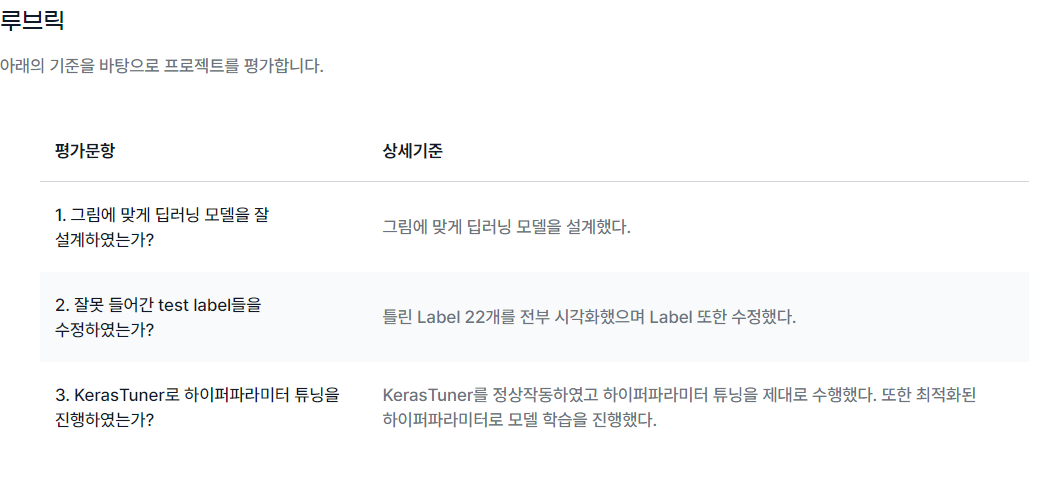

In [19]:
!mkdir ~/aiffel/mlops1 # 디렉토리 생성
!pip install keras-tuner # KerasTuner 설치

mkdir: cannot create directory ‘/aiffel/aiffel/mlops1’: File exists


## Data Centric AI 맛보기
---
Data Centric AI를 공부했으니 한번 맛은 봐야겠죠? Data Centric AI를 정석적으로 진행한다면 훈련 데이터셋과 테스트 데이터셋을 전부 열어서 확인해서 틀린 것이 없는지 검수해야 한다.
하지만 일일이 해볼만한 시간은 존재하지 않으니 사람들이 미리 검수했던 내용들을 기반으로 프로젝트를 진행하겠다.

* [labelerrors.com](https://labelerrors.com/)

labelerrors.com은 Data Centric AI에서 가장 많이 활용하고 있는 파이썬 라이브러리인 cleanlab을 만든 개발자들이 공개한 사이트이다. labelerrors.com은 이름에서 알 수 있듯이 테스트 데이터와 label이 잘못 붙어 있는 사례를 모아 보여준다.
labelerrors.com에서 CIFAR10 테스트 데이터셋을 확인하고 아래 조그맣게 있는 ID를 기준으로 직접 데이터셋을 시각화하고 실제 label이 잘못 붙어있다면 label을 수정해주자.

In [20]:
# 필요한 라이브러리 불러오기
import tensorflow as tf
import keras
import keras_tuner as kt
from sklearn.model_selection import train_test_split
import os

우리가 이번에 사용할 데이터셋은 CIFAR10이다. keras에 내장되어 있는 datasets으로 불러오자.

In [21]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

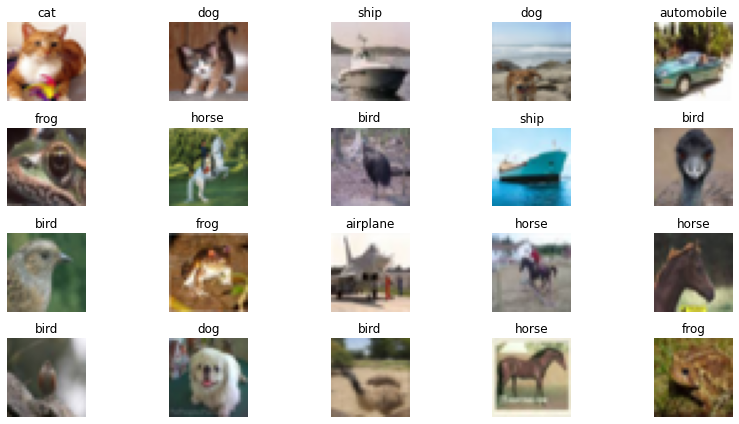

In [26]:
# 데이터셋 확인하기
import matplotlib.pyplot as plt
import numpy as np

# 클래스명
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# 데이터셋에서 랜덤으로 20개의 이미지 가져오기
num_images = 20
fig, axes = plt.subplots(4, 5, figsize=(12, 6))

for i in range(num_images):
    random_index = np.random.randint(0, len(x_train))
    image = x_train[random_index]
    label_index = np.squeeze(y_train[random_index])  # 1차원으로 변환

    label = class_names[label_index]

    row = i // 5
    col = i % 5

    axes[row, col].imshow(image)
    axes[row, col].axis('off')
    axes[row, col].set_title(label)

plt.tight_layout()
plt.show()

* 확인을 해보니, 테스트 데이터뿐만 아니라 훈련 데이터셋에서도 라벨이 잘못된 것을 발견할 수 있었다.
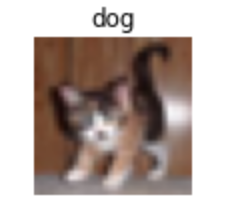

일단 루브릭 기준으로 잘못된 테스트 레이블을 시각화하고 수정해보자.

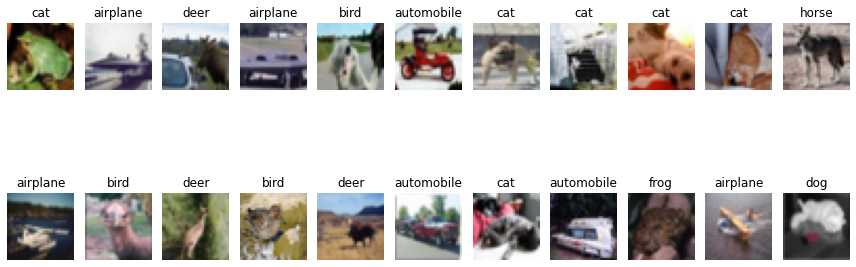

In [35]:
# 잘못된 테스트 데이터셋 레이블 시각화
label_numbers = [2405, 6877, 8058, 2532, 7657, 1969, 2804, 6792, 1227, 5191, 5690, 1718, 2592, 4794, 5960, 165, 9227, 5632, 9352, 7846, 6966, 5468]

# 데이터셋에서 오류가 있는 22개의 이미지 시각화
num_images = 22
fig, axes = plt.subplots(2, 11, figsize=(12, 6))

for i, v in enumerate(label_numbers):
    image = x_test[v]
    label_index = np.squeeze(y_test[v])  # 1차원으로 변환

    label = class_names[label_index]

    row = i // 11
    col = i % 11

    axes[row, col].imshow(image)
    axes[row, col].axis('off')
    axes[row, col].set_title(label)

plt.tight_layout()
plt.show()


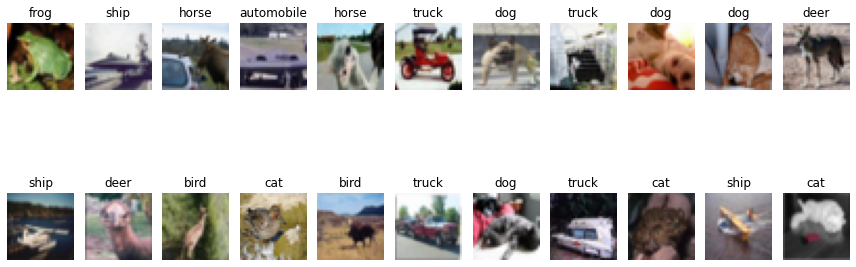

In [36]:
# 잘못된 테스트 데이터셋 레이블을 수정
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
label_numbers = [2405, 6877, 8058, 2532, 7657, 1969, 2804, 6792, 1227, 5191, 5690, 1718, 2592, 4794, 5960, 165, 9227, 5632, 9352, 7846, 6966, 5468]
new_class_names = ['frog', 'ship', 'horse', 'automobile', 'horse', 'truck', 'dog', 'truck', 'dog', 'dog', 'deer', 'ship', 'deer', 'bird', 'cat', 'bird', 'truck', 'dog', 'truck', 'cat', 'ship', 'cat']
new_labels = [class_names.index(name) for name in new_class_names]

for i, v in enumerate(label_numbers):
    y_test[v] = new_labels[i]

# 수정된 사항을 시각화
num_images = 22
fig, axes = plt.subplots(2, 11, figsize=(12, 6))

for i, v in enumerate(label_numbers):
    image = x_test[v]
    label_index = np.squeeze(y_test[v])  # 1차원으로 변환

    label = class_names[label_index]

    row = i // 11
    col = i % 11

    axes[row, col].imshow(image)
    axes[row, col].axis('off')
    axes[row, col].set_title(label)

plt.tight_layout()
plt.show()

* 시각화를 통해 라벨이 올바르게 수정된 것을 확인할 수 있었다.

이제 데이터 전처리를 진행해보자.

In [37]:
# 데이터셋 픽셀 값을 0~1의 값으로 정규화
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# 학습 레이블인 y_train을 one-hot encoding 형태로 변환
y_train = tf.keras.utils.to_categorical(y_train) # (ex.숫자 3에 해당하는 클래스는 [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]와 같이 표현)
y_test = tf.keras.utils.to_categorical(y_test)

scikit-learn에 내장되어 있는 train_test_split으로 train data와 validation data를 나누어 준다.

In [38]:
# 데이터 확인
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(50000, 32, 32, 3)
(50000, 10)
(10000, 32, 32, 3)
(10000, 10)


In [39]:
# train_test_split 함수는 학습 데이터셋을 무작위로 섞은 후, 주어진 비율에 따라 학습용과 검증용으로 나누어주는 함수
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.2) # 80%의 X_train data, 20%의 X_val data

print(x_train.shape) # (이미지 수, 가로 크기, 세로 크기, 채널 수)
print(x_val.shape)

(40000, 32, 32, 3)
(10000, 32, 32, 3)


## 모델 고정해서 사용하기
---
이번 CIFAR10 프로젝트의 경우에는 모델을 고정해서 사용할 예정이다. 모델의 경우에는 다음과 같은 그림으로 구성해라.
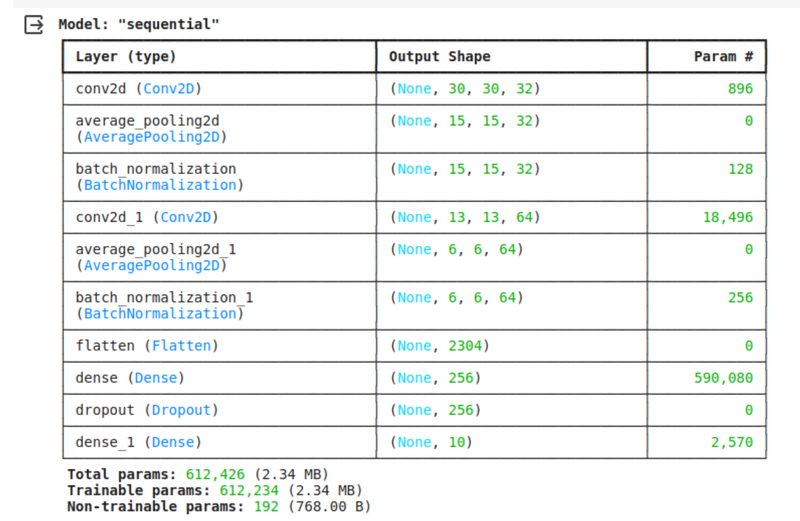

이번에는 짜여진 DeepTuner를 살펴보겠다!

DeepTuner의 경우 kerastuner.Tuner를 인자로 하는 class이며 class에서 수행하는 함수는 run_trial, save_model load_model이다.

run_trial 함수에서 제일 중요한 부분은 hypermodel과 trial이다.

KerasTuner에서의 hypermodel은 모델을 공유 및 재사용하기 위해 검색 공간을 캡슐화하는 모델이다. 

hypermodel의 경우 hp라는 인수를 활용해서 keras.Model을 생성한다. 즉 hypermodel은 우리가 만들고 싶은 모델을 쌓는 과정을 거치는데 이때 하이퍼파라미터 튜닝에 대한 검색공간을 만들어줄때 hp라는 인수를 사용해서 만든 모델이다. hypermodel의 경우 build 메소드를 활용하면 모델이 빌드가 되면서 하이퍼파라미터 튜닝이 시작한다.

trial의 경우에는 Oracle에 속하는 class이다. 

Oracle이란 KerasTuner의 모든 검색 알고리즘에서 사용하는 기본 클래스이며 크게 RandomSearchOracle, BayesianOptimizationOracle, HyperbandOracle이 있다. 쉽게 설명하면 Oracle은 KerasTuner가 하이퍼파라미터를 정할 때 사용하는 알고리즘이라고 생각하면 된다! 여기서 trial.hyperparameter는 Oracle이 찾아야 하는 하이퍼파라미터이다. 즉 hypermodel에서의 hp이다. model.fit()을 할때 batch_size도 고를 수 있게 만들었다.

In [43]:
# 모델 하이퍼파라미터를 조정하기 위한 Keras Tuner의 사용자 정의 클래스인 DeepTuner를 정의
class DeepTuner(kt.Tuner): # DeepTuner 클래스를 kt.Tuner 클래스를 상속하여 정의, Keras Tuner의 튜닝을 위한 사용자 정의 클래스
    def run_trial(self, trial, X, y, validation_data, **fit_kwargs): # run_trial 메서드는 각 실험(trial)을 실행하는 역할
                                                                     # 이 메서드는 튜닝 과정 중에 호출되며, 각 실험에 대한 모델을 생성하고 학습을 진행
                                                                     # trial: 튜닝할 하이퍼파라미터 및 관련 정보를 담은 Trial 객체
                                                                     # X: 학습 데이터
                                                                     # y: 학습 레이블
                                                                     # validation_data: 검증 데이터
                                                                     # **fit_kwargs: model.fit 메서드에 전달되는 추가적인 인자들
        model = self.hypermodel.build(trial.hyperparameters) # trial.hypermodel.build를 통해 현재 실험의 하이퍼파라미터를 사용하여 모델을 생성
                                                             # hypermodel은 튜닝 대상인 모델 아키텍처를 정의하는데 사용되는 객체
        model.fit(X, y, batch_size=trial.hyperparameters.Choice( # 생성된 모델을 학습, 배치 크기(batch_size)는 trial.hyperparameters.Choice를 사용하여 선택된 값 중 하나로 지정
            'batch_size', [16, 32]), **fit_kwargs)   # 즉, 주어진 선택지 중에서 튜닝 프로세스에서 최적의 배치 크기를 찾도록 한다


        x_val, y_val = validation_data # 검증 데이터를 추출
        eval_scores = model.evaluate(x_val, y_val) # 학습된 모델을 사용하여 검증 데이터에 대한 평가를 수행
        return {name: value for name, value in zip( # 검증 데이터에 대한 평가 결과를 딕셔너리 형태로 반환
            model.metrics_names,                    # 딕셔너리의 키는 메트릭의 이름이고, 값은 해당 메트릭의 평가 결과
            eval_scores)}

이번에는 build_model쪽을 보도록 하겠다.

build_model은 위에서 설명한것처럼 hypermodel을 만들어줘야 한다. 만들어진 hypermodel은 총 2가지 기법이 들어가 있으며 주의사항도 1가지 있다.

우선 주의사항부터 말하자면, 해당 모델의 경우 hypermodel이기 때문에 Input지정이 필수이다! 그렇기에 넣고 싶은 모델에 대한 shape을 꼭 기재해야 한다!

사용된 첫번째 기법은 바로 layer의 숫자도 KerasTuner에게 맡기는 것이다. for문을 확인해보겠다.

첫번째 for문의 경우 hp.Int로 만들어 검색공간은 정수로 만들고 가장 작은값을 1로 가장 큰값을 10으로 두었다. 이렇게 설정하면 최소 1개에서 최소 10개의 layer를 쌓을 수 있게 설정할 수 있다.

쌓고싶은 layer는 conv2D인데 kernel_size는 (3,3)이며 차원수는 최소 32에서 최대 256으로 바꾸었다.

두번째 for문을 살펴보겠다. 두번째 for문도 최소 1개에서 3개로 설정했지만 Dense Layer의 경우 나올 수 있는 차원을 32,64,128,256중 1개를 선택하도록 만들었다.

이러한 방식으로 hypermodel을 만들면 하고싶은 하이퍼 파라미터 튜닝을 진행할 수 있다.

In [46]:
from tensorflow.keras import layers

# Keras Tuner를 사용하여 CNN(Convolutional Neural Network) 아키텍처의 하이퍼파라미터 튜닝을 위한 모델을 정의하는 함수
def build_model(hp):
    model = tf.keras.Sequential() # Sequential 모델을 생성, 이 모델은 각 레이어를 차례로 쌓아가는 방식으로 구성
    model.add(tf.keras.Input(shape = x_train.shape[1:], name = 'inputs')) # 첫 번째 레이어로 입력 레이어를 추가, 이 레이어는 입력 이미지의 모양을 정의
    model.add(layers.Conv2D(32, 
                            kernel_size=(3, 3), strides=(1, 1), activation=hp.Choice(f'Conv2D1_activation', values=['relu', 'tanh'])))
    model.add(layers.AveragePooling2D(pool_size=(2,2)))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(64,
                            kernel_size=(3,3),
                            strides=(1,1),
                            activation=hp.Choice(f'Conv2D2_activation', values=['relu', 'tanh'])))
    model.add(layers.AveragePooling2D(pool_size=(2,2)))
    model.add(layers.BatchNormalization())
    model.add(layers.Flatten()) # CNN 레이어를 거쳐 얻은 특징 맵을 1차원으로 펼치는 Flatten 레이어를 추가
    model.add(layers.Dense(256, activation=hp.Choice('dense_activation', values=['relu', 'tanh'])))
    model.add(layers.Dropout(hp.Choice(f'drop_rate', values=[0.3,0.5])))
    model.add(layers.Dense(10, activation='softmax', name = 'outputs')) 
    model.compile(optimizer = 'adam', loss='categorical_crossentropy',metrics=['accuracy'])
    
    return model

## 하이퍼파라미터 튜닝
---

In [47]:
# Keras Tuner를 사용하여 딥러닝 모델의 하이퍼파라미터 튜닝을 수행하는 과정
my_keras_tuner = DeepTuner(       # DeepTuner 클래스의 인스턴스인 my_keras_tuner를 생성
    oracle=kt.oracles.BayesianOptimizationOracle( # BayesianOptimizationOracle를 사용하여 Bayesian 최적화를 수행
        objective=kt.Objective('accuracy', 'max'),# 목표는 'accuracy'를 최대화하는 것으로 설정
        max_trials=10, # 최대 시도 횟수는 10회로 설정
        seed=42), # 랜덤 시드(seed)는 42로 지정
    hypermodel=build_model, # hypermodel 인자에는 하이퍼파라미터를 튜닝할 모델을 정의한 함수인 build_model이 전달된다
    overwrite=True, # overwrite=True로 설정하여 이전에 저장된 튜닝 기록을 덮어쓰도록 한다
    project_name='my_keras_tuner') # project_name은 튜닝 프로세스에 대한 이름으로 설정

# 해당 모델 학습시간은 약 10분정도 걸립니다!
my_keras_tuner.search( # search 메서드를 호출하여 하이퍼파라미터 튜닝을 수행
    x_train, y_train, validation_data=(x_val, y_val), epochs=3) # 학습 데이터인 X_train 및 y_train을 사용하고, 검증 데이터로는 X_val 및 y_val을 사용
                                                                # 최대 3 에폭(epochs=3) 동안 튜닝을 수행
                                                                #  이 과정에서 Bayesian 최적화를 사용하여 각 시도에서 모델을 학습하고 
                                                                # 검증 데이터에 대한 정확도를 최대화하는 최적의 하이퍼파라미터를 찾는다.
# 최종적으로는 최적의 하이퍼파라미터 조합을 찾게 되고, 해당 모델은 향상된 성능을 가지게 된다      

Trial 10 Complete [00h 00m 16s]
accuracy: 0.5428000092506409

Best accuracy So Far: 0.6784999966621399
Total elapsed time: 00h 04m 34s


가장 좋은 모델을 뽑는 방법은 KerasTuner.get_best_hyperparamters를 이용해서 가장 좋은 하이퍼파라미터를 뽑아내는 작업이다. 하이퍼파라미터를 뽑았으면 build_model()에 집어넣어 가장 좋은 모델을 선언한다.

가장 좋은 모델을 확인해 보자!

In [48]:
# Keras Tuner를 통해 얻은 최적의 하이퍼파라미터를 사용하여 모델을 구성하고, 해당 모델의 구조를 출력하는 과정
best_hps = my_keras_tuner.get_best_hyperparameters(num_trials=10)[0] # get_best_hyperparameters 메서드를 사용하여 최적의 하이퍼파라미터를 얻는다
                                                                     # num_trials는 최적의 하이퍼파라미터를 찾기 위한 시도 횟수로, 여기서는 10으로 설정
                                                                     # 반환된 리스트에서 첫 번째 하이퍼파라미터를 선택하여 best_hps에 저장 
model = build_model(best_hps) # best_hps를 사용하여 build_model 함수를 호출하여 최적의 하이퍼파라미터를 적용한 모델을 생성
model.summary() # 생성된 모델의 구조를 출력

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_22 (Conv2D)           (None, 30, 30, 32)        896       
_________________________________________________________________
average_pooling2d_22 (Averag (None, 15, 15, 32)        0         
_________________________________________________________________
batch_normalization_22 (Batc (None, 15, 15, 32)        128       
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 13, 13, 64)        18496     
_________________________________________________________________
average_pooling2d_23 (Averag (None, 6, 6, 64)          0         
_________________________________________________________________
batch_normalization_23 (Batc (None, 6, 6, 64)          256       
_________________________________________________________________
flatten_11 (Flatten)         (None, 2304)            

최고의 하이퍼 파라미터만 뽑았기 때문에 아직 모델학습이 되지 않았다! 이번에 epoch을 5번정도 주어서 모델학습을 진행해보자!

만일 무거운 모델을 돌릴 경우 하이퍼파라미터 튜닝작업이 매우 느려질 수 있다. 그때의 경우 하이퍼파라미터 튜닝할때 epoch을 3-4정도로 작게 준 다음 최고의 하이퍼파라미터를 뽑아낸 다음 본격적인 모델학습때 epoch을 넉넉하게 주는 것도 방법이다!

In [50]:
model.fit(x_train, y_train, batch_size=32, epochs = 5)

Epoch 1/5
1250/1250 [==============================] - 4s 3ms/step - loss: 1.6488 - accuracy: 0.4585
Epoch 2/5
1250/1250 [==============================] - 4s 3ms/step - loss: 1.1571 - accuracy: 0.5917
Epoch 3/5
1250/1250 [==============================] - 4s 3ms/step - loss: 0.9850 - accuracy: 0.6547
Epoch 4/5
1250/1250 [==============================] - 4s 3ms/step - loss: 0.8452 - accuracy: 0.7053
Epoch 5/5
1250/1250 [==============================] - 4s 3ms/step - loss: 0.7291 - accuracy: 0.7441


모델 평가를 진행해보자.

In [52]:
model.evaluate(x_test, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 1.1458 - accuracy: 0.6184


[1.1458330154418945, 0.618399977684021]

이제 모델을 저장할 차례이다.

우리가 이전까지 자주 사용한 저장방법은 HDF5파일 (.h5)로 저장하는 방법이었다.

HDF파일로 저장하는 방식은 이전 Keras에서 모델을 저장하는 방식이었으나 사실 이 방법은 TensorFlow나 Keras에서 그다지 선호하지 않는 저장방식이다.

TensorFlow의 경우 공식적으로 지원하는 모델 저장방식은 SavedModel이다.

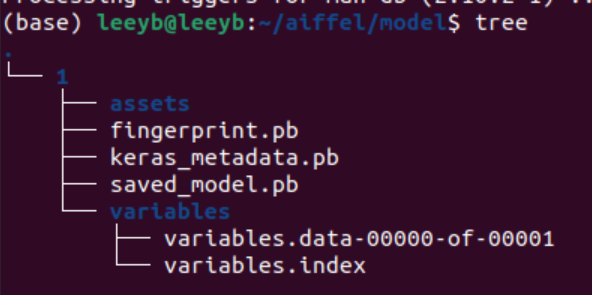
[SavedModel 파일구조]

SavedModel은 .h5파일처럼 모델의 가중치와 모델을 전부 하나의 파일로 관리하는 방식이 아닌 모델, 가중치를 따로 구분해서 저장하는 방식이다.

SavedModel은 크게 3가지로 구성되어 있다.

* saved_model.pb : pb는 프로토콜 버퍼를 의미하며 해당 파일은 내보낸 모델 그래프 구조를 포함하고 있다.
* variables : 내보낸 변수값이 있는 이진 파일과 내보낸 모델 그래프에 해당하는 체크포인트를 포함하고 있다
* assets : 내보낸 모델을 불러올 때 추가적인 파일이 필요한 경우 이 폴더에 파일이 생성된다.

이 방식으로 진행한다면 모델을 배포할 때 유리하다.

Keras의 경우 .keras파일을 선호한다. .keras파일은 .h5파일과 마찬가지로 가중치와 모델을 전부 하나의 파일로 관리한다.

In [53]:
# 훈련된 딥러닝 모델을 저장하는 과정
save_path = os.getenv('HOME') + '/aiffel/mlops/best_model/1' # 모델을 저장할 경로를 설정
fname = os.path.join(save_path, 'model') # os.path.join 함수를 사용하여 모델 파일의 경로를 생성, save_path 디렉토리에 'model'이라는 파일명을 갖는 경로를 생성
model.save(fname) # 생성된 경로에 따라 모델을 저장
                  # save 메서드는 모델의 아키텍처, 가중치, 옵티마이저 상태 등을 포함한 전체 모델을 지정된 파일 경로에 저장
                  # 저장된 모델은 나중에 불러와서 예측을 수행하거나 추가적인 훈련을 진행할 수 있다

INFO:tensorflow:Assets written to: /aiffel/aiffel/mlops/best_model/1/model/assets


### 회고문

꼭 알아야 하는 주제를 공부할 수 있었던 유익한 노드라는 생각이 든다. 다만 중요한 주제임에도 불구하고 노드 학습을 진행할 수 있는 시간이 짧았던 것이 아쉬웠다. 새로운 지식의 양이 많아서 천천히 정리하면서 공부했다면 더 좋았을 것 같다. 아직 배포하는 것과 TFLite로 경량화 모델을 만드는 게 이해가 가지 않아서, 노드를 전반적으로 다시 천천히 공부해야 할 것 같다.

#### KEEP
: LMS 환경에서 배포가 안 된다는 것을 알았지만, 배포가 가능하도록 우분투 등을 다운받아서 환경을 구축해놨다.

#### PROBELM
: 아직 전반적인 내용이 숙지가 덜 됐다

#### TRY
: 노드를 전반적으로 다시 복습하고, 개념적인 부분도 이해하기 위해 구글링을 해봐야겠다.